## Chapter 14: Causal Social Science Research 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import requests
import zipfile
from io import BytesIO, TextIOWrapper
from causallib.estimation import IPW
from causallib.evaluation import evaluate
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading the datasets

In [3]:
# Download and unzip NJ minimum wage dataset
url = "https://davidcard.berkeley.edu/data_sets/njmin.zip"
response = requests.get(url)
z = zipfile.ZipFile(BytesIO(response.content))

# Load the main dataset
df = (
    pd.read_csv(
        z.open("public.dat"),
        sep=r"\s+",
        header=None,
        engine="python"
    )
    .applymap(lambda x: pd.to_numeric(x, errors="coerce"))
)

# Read the codebook (contains column names and descriptions)
with TextIOWrapper(z.open("codebook"), encoding="cp437") as f:
    codebook = f.readlines()

# Extract relevant lines (skip formatting/headers)
relevant_lines = (
    codebook[7:11] + codebook[13:19] + codebook[21:38] + codebook[40:59]
)

# Parse column names and descriptions
cols = [line.split()[0] for line in relevant_lines]
descriptions = [" ".join(line.split()[4:]).strip() for line in relevant_lines]

# Assign column names
df.columns = cols

# Create dictionary of column -> description
column_descriptions = dict(zip(cols, descriptions))

In [4]:
df

,SHEET,CHAIN,CO_OWNED,STATE,SOUTHJ,CENTRALJ,NORTHJ,PA1,PA2,SHORE,...,FIRSTIN2,SPECIAL2,MEALS2,OPEN2R,HRSOPEN2,PSODA2,PFRY2,PENTREE2,NREGS2,NREGS112
0,46,1,0,0,0,0,0,1,0,0,...,0.08,1.0,2.0,6.5,16.5,1.03,NaN,0.94,4.0,4.0
1,49,2,0,0,0,0,0,1,0,0,...,0.05,0.0,2.0,10.0,13.0,1.01,0.89,2.35,4.0,4.0
2,506,2,1,0,0,0,0,1,0,0,...,0.25,NaN,1.0,11.0,11.0,0.95,0.74,2.33,4.0,3.0
3,56,4,1,0,0,0,0,1,0,0,...,0.15,0.0,2.0,10.0,12.0,0.92,0.79,0.87,2.0,2.0
4,61,4,1,0,0,0,0,1,0,0,...,0.15,0.0,2.0,10.0,12.0,1.01,0.84,0.95,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,423,2,1,1,0,0,1,0,0,0,...,0.50,0.0,1.0,11.0,11.0,1.05,0.84,2.32,3.0,2.0
406,424,2,1,1,0,0,1,0,0,0,...,0.50,0.0,1.0,11.0,14.0,1.05,0.94,2.32,5.0,3.0
407,426,3,1,1,0,0,1,0,0,0,...,0.25,1.0,2.0,6.0,18.0,1.11,1.05,1.05,6.0,5.0
408,427,4,0,1,0,0,1,0,0,0,...,NaN,1.0,2.0,10.5,12.5,1.11,1.09,2.07,2.0,2.0


### Feature description

In [5]:
column_descriptions

{'SHEET': 'sheet number (unique store id)',
 'CHAIN': 'chain 1=bk; 2=kfc; 3=roys; 4=wendys',
 'CO_OWNED': '1 if company owned',
 'STATE': '1 if NJ; 0 if Pa',
 'SOUTHJ': '1 if in southern NJ',
 'CENTRALJ': '1 if in central NJ',
 'NORTHJ': '1 if in northern NJ',
 'PA1': '1 if in PA, northeast suburbs of Phila',
 'PA2': '1 if in PA, Easton etc',
 'SHORE': '1 if on NJ shore',
 'NCALLS': 'number of call-backs*',
 'EMPFT': '# full-time employees',
 'EMPPT': '# part-time employees',
 'NMGRS': "# managers/ass't managers",
 'WAGE_ST': 'starting wage ($/hr)',
 'INCTIME': 'months to usual first raise',
 'FIRSTINC': 'usual amount of first raise ($/hr)',
 'BONUS': '1 if cash bounty for new workers',
 'PCTAFF': '% employees affected by new minimum',
 'MEALS': 'free/reduced price code (See below)',
 'OPEN': 'hour of opening',
 'HRSOPEN': 'number hrs open per day',
 'PSODA': 'price of medium soda, including tax',
 'PFRY': 'price of small fries, including tax',
 'PENTREE': 'price of entree, including t

In [6]:
df.shape

(410, 46)

In [7]:
df.columns

Index(['SHEET', 'CHAIN', 'CO_OWNED', 'STATE', 'SOUTHJ', 'CENTRALJ', 'NORTHJ',
       'PA1', 'PA2', 'SHORE', 'NCALLS', 'EMPFT', 'EMPPT', 'NMGRS', 'WAGE_ST',
       'INCTIME', 'FIRSTINC', 'BONUS', 'PCTAFF', 'MEALS', 'OPEN', 'HRSOPEN',
       'PSODA', 'PFRY', 'PENTREE', 'NREGS', 'NREGS11', 'TYPE2', 'STATUS2',
       'DATE2', 'NCALLS2', 'EMPFT2', 'EMPPT2', 'NMGRS2', 'WAGE_ST2',
       'INCTIME2', 'FIRSTIN2', 'SPECIAL2', 'MEALS2', 'OPEN2R', 'HRSOPEN2',
       'PSODA2', 'PFRY2', 'PENTREE2', 'NREGS2', 'NREGS112'],
      dtype='object')

### EDA Analysis

In [8]:
df['FTE_EMP'] = df['EMPFT'] + df['NMGRS'] + 0.5 * df['EMPPT']
df['FTE_EMP2'] = df['EMPFT2'] + df['NMGRS2'] + 0.5 * df['EMPPT2']
df['price_full_meal'] = df['PENTREE'] + df['PFRY'] + df['PSODA']
df['price_full_meal2'] = df['PENTREE2'] + df['PFRY2'] + df['PSODA2']
df['fulltime_employee_perc'] = df['EMPFT'] / df['FTE_EMP']
df['fulltime_employee_perc2'] = df['EMPFT2'] / df['FTE_EMP2']

df['salary1'] = df['WAGE_ST'] == 4.25
df['salary2'] = df['WAGE_ST2'] == 4.25
df['salary3'] = df['WAGE_ST2'] == 5.05

state_map = {0: "PA", 1: "NJ"}  
df["state"] = df["STATE"].map(state_map)

In [9]:
df = pd.get_dummies(df, prefix="C", dtype=int, columns=["CHAIN"]).rename(
        columns={'C_1': "Burger King", 'C_2': "KFC",
                  'C_3': "Roy Rogers", 'C_4': "Wendy's"})

chains = ['Burger King', 'KFC', 'Roy Rogers', 'Wendy\'s']
result_chains = df.groupby(['state'])[chains].mean()
result_chains.index.name = None 
result_chains = result_chains.T*100
result_chains.round(2)

,NJ,PA
Burger King,41.09,44.30
KFC,20.54,15.19
Roy Rogers,24.77,21.52
Wendy's,13.60,18.99


In [10]:
result_coowned = df.groupby(['STATE'])['CO_OWNED'].mean().to_frame()
result_coowned.index.name = None 
result_coowned = result_coowned.rename(index={0: "PA", 1: "NJ"},
                    columns={'CO_OWNED': 'Company-owned (%)'}).T*100
result_coowned.round(2)

,PA,NJ
Company-owned (%),35.44,34.14


In [11]:
pre_treat_cols = ['FTE_EMP', 'fulltime_employee_perc', 'WAGE_ST',
                  'salary1', 'price_full_meal', 'HRSOPEN']
result_w1 = df.groupby(['state'])[pre_treat_cols].mean()
result_w1.index.name = None 
result_w1 = result_w1.rename(
            columns={'FTE_EMP': 'FTE Employment',
                    'fulltime_employee_perc': 'Full-time employees (%)',
                    'WAGE_ST': 'Starting Wage',
                    'salary1': 'Wage = $4.25 (percentage)',
                    'price_full_meal': 'Price of full meal',
                    'HRSOPEN': 'Hours open on weekdays'}).T
result_w1.loc['Full-time employees (%)'] *= 100
result_w1.loc['Wage = $4.25 (percentage)'] *= 100
result_w1.round(2)

,NJ,PA
FTE Employment,20.44,23.33
Full-time employees (%),32.85,35.04
Starting Wage,4.61,4.63
Wage = $4.25 (percentage),30.51,32.91
Price of full meal,3.35,3.04
Hours open on weekdays,14.42,14.53


In [12]:
post_treat_cols = ['FTE_EMP2','fulltime_employee_perc2','WAGE_ST2',
                   'salary2', 'salary3', 'price_full_meal2', 'HRSOPEN2']
result_w2 = df.groupby(['state'])[post_treat_cols].mean()
result_w2.index.name = None 
result_w2 = result_w2.rename(
            columns={'FTE_EMP2': 'FTE Employment',
                     'fulltime_employee_perc2': 'Full-time employees (%)',
                     'WAGE_ST2': 'Starting Wage',
                     'salary2': 'Wage = $4.25 (percentage)',
                     'salary3': 'Wage = $5.05 (percentage)',
                     'price_full_meal2': 'Price of full meal',
                     'HRSOPEN2': 'Hours open on weekdays'}).T
result_w2.loc['Full-time employees (%)'] *= 100
result_w2.loc['Wage = $4.25 (percentage)'] *= 100
result_w2.loc['Wage = $5.05 (percentage)'] *= 100
result_w2.round(2)

,NJ,PA
FTE Employment,21.03,21.17
Full-time employees (%),35.87,30.38
Starting Wage,5.08,4.62
Wage = $4.25 (percentage),0.00,25.32
Wage = $5.05 (percentage),85.50,1.27
Price of full meal,3.41,3.03
Hours open on weekdays,14.42,14.65


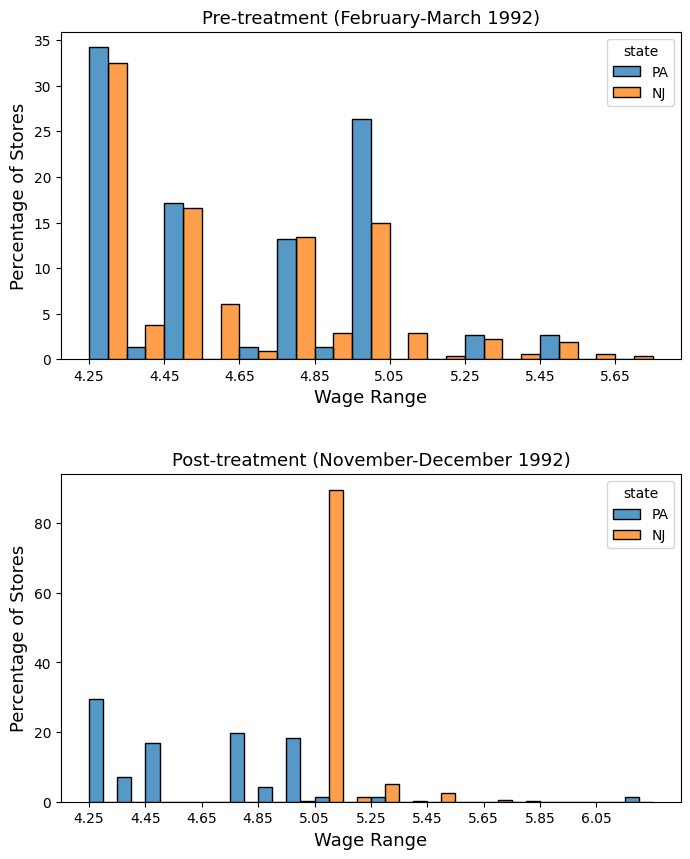

In [13]:
cols = ["WAGE_ST", "WAGE_ST2"]
titles = [
    "Pre-treatment (February-March 1992)",
    "Post-treatment (November-December 1992)"
]

plt.figure(figsize=(8, 10))  

for i, (col, title) in enumerate(zip(cols, titles), start=1):
    ax = plt.subplot(2, 1, i)  
    sns.histplot(
        data=df,
        x=col,
        hue="state",
        binwidth=0.1,
        stat="percent",
        common_norm=False,
        multiple="dodge",
        ax=ax
    )
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Wage Range", fontsize=13)
    ax.set_ylabel("Percentage of Stores", fontsize=13)
    ax.set_xticks(np.arange(4.25, df[col].max(), 0.2))

plt.subplots_adjust(hspace=0.35)
plt.show()

### Causal model

In [14]:
T = df['STATE']
Y = df['FTE_EMP2']
Y[T==1].mean()-Y[T==0].mean()

np.float64(-0.13815494849977483)

In [15]:
df[df['STATE'] == 0]['FTE_EMP2'].mean() - df[df['STATE'] == 0]['FTE_EMP'].mean()

np.float64(-2.1655844155844157)

In [16]:
df[df['STATE'] == 1]['FTE_EMP2'].mean() - df[df['STATE'] == 1]['FTE_EMP'].mean()

np.float64(0.5880213673961663)

In [17]:
0.5880213673961663+2.1655844155844157

2.753605782980582

In [18]:
covariates = ['FTE_EMP', 'KFC', 'Wendy\'s']
for covariate in covariates:
    mean_xi_t = df[df['STATE']==1][covariate].mean()
    mean_xi_c = df[df['STATE']==0][covariate].mean()
    std_xi_t = df[df['STATE']==1][covariate].std(ddof=0)
    std_xi_c = df[df['STATE']==0][covariate].std(ddof=0)
    smd = (mean_xi_t - mean_xi_c) / np.sqrt(std_xi_t**2 + std_xi_c**2)
    print(f"SMD for {covariate}:", np.round(smd, 3))


SMD for FTE_EMP: -0.194
SMD for KFC: 0.099
SMD for Wendy's: -0.104


### Estimation using Linear regression

In [19]:
df['delta_emp'] = df['FTE_EMP2'] - df['FTE_EMP']
final_df = df.dropna(subset=['FTE_EMP2', 'FTE_EMP',
                             'WAGE_ST', 'WAGE_ST2'])

model1 = sm.OLS(final_df['delta_emp'],
                sm.add_constant(final_df[['Roy Rogers',                                              
               'KFC', 'Wendy\'s', 'STATE', 'CO_OWNED']]))
results = model1.fit()
cols = {"Estimation": [results.params['STATE']],
   "Standard error": [results.bse['STATE']],
   "p-value": [results.pvalues['STATE']],
   "95% conf interval":   
       [results.conf_int().loc["STATE"].round(3).tolist()]}

output = pd.DataFrame(cols, index=["STATE"])
output.round(3)

,Estimation,Standard error,p-value,95% conf interval
STATE,2.282,1.197,0.057,"[-0.073, 4.636]"


In [20]:
df['GAP'] = np.where(
    (df['STATE'] == 1) & (df['WAGE_ST'] < 5.05),
    (5.05 - df['WAGE_ST']) / df['WAGE_ST'],
    0
)
final_df = df.dropna(subset=['FTE_EMP2', 'FTE_EMP',
                             'WAGE_ST', 'WAGE_ST2'])

model2 = sm.OLS(final_df['delta_emp'], 
                sm.add_constant(final_df[['Roy Rogers', 
               'KFC', 'Wendy\'s', 'CO_OWNED', 'GAP',
               ]]))
results = model2.fit()
cols = {"Estimation": [results.params['GAP']],
   "Standard error": [results.bse['GAP']],
   "p-value": [results.pvalues['GAP']], 
   "95% conf interval":   
       [results.conf_int().loc["GAP"].round(3).tolist()]}
output = pd.DataFrame(cols, index=["GAP"])
output.round(3)

,Estimation,Standard error,p-value,95% conf interval
GAP,16.363,6.237,0.009,"[4.095, 28.631]"


In [21]:
final_df[final_df['STATE']==1]['GAP'].mean() * 16.363	

np.float64(1.7109302862753615)

### Estimation using IPTW

In [22]:
final_df = df.dropna(subset=['FTE_EMP2', 'FTE_EMP',
                             'WAGE_ST', 'WAGE_ST2'])

cov_list = ['FTE_EMP', 'KFC', 'Roy Rogers', 
            'Wendy\'s', 'WAGE_ST', 'CO_OWNED']

X = final_df[cov_list]
Y = final_df['FTE_EMP2']  
T = final_df['STATE']

learner = LogisticRegression(penalty=None, solver='lbfgs',
                             max_iter=500)    


ipw = IPW(learner)
ipw.fit(X, T)

outcomes = ipw.estimate_population_outcome(X, T, Y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])
print("Outcomes:")
print(outcomes)
print("Effect: ", effect['diff'])

Outcomes:
0    20.714231
1    21.398265
dtype: float64
Effect:  0.684033518110752


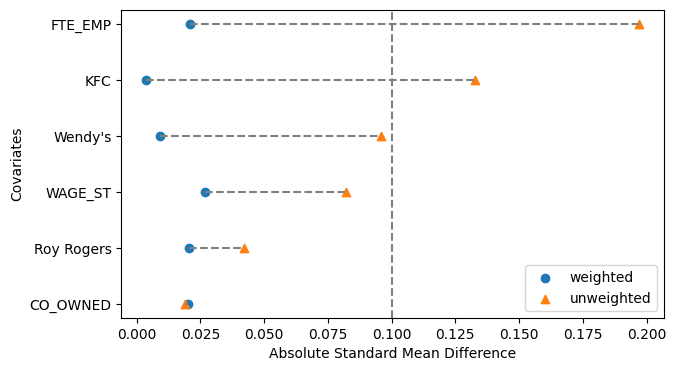

In [23]:
evaluation_results = evaluate(ipw, X, T, Y)
plt.figure(figsize=(7, 4))
evaluation_results.plot_covariate_balance(kind="love", 
                                          thresh=0.1)
plt.show()